In [1]:
import tensorflow as tf


In [2]:
tf.__version__

'2.15.0'

In [3]:
# To generate GIF
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-7b6pg82k
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-7b6pg82k
  Resolved https://github.com/tensorflow/docs to commit 75b2672b5bed8ca0995663536db84bd9a39b8896
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.5.3.31743-py3-none-any.whl size=182531 sha256=192c0d3670813d119706632c3b655f77086a61f7b295aa5ab635d6621e451f97
  Stored in directory: /tmp/pip-ephem-wheel-cache-z3u4b2gm/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import time

from IPython import display

In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [6]:
# Reshape the Images
train_images = train_images.reshape(train_images.shape[0], 28, 28,1).astype("float32")
train_images = (train_images - 127.5) / 127.5 ## Normalize the images to [ -1 , 1]

In [7]:
train_images.shape

(60000, 28, 28, 1)

In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256


In [9]:
## Batch and Shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [10]:
train_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

## Creating the Model

    Both the generator and Discriminator are define using the Keras Sequential API


In [11]:
# The Generator
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias= False, input_shape = (100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256)  ## Note : These is the batch size

  model.add(layers.Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same', use_bias = False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5,5), strides = (2, 2), padding = "same", use_bias = False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = "same", use_bias = False, activation = 'tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

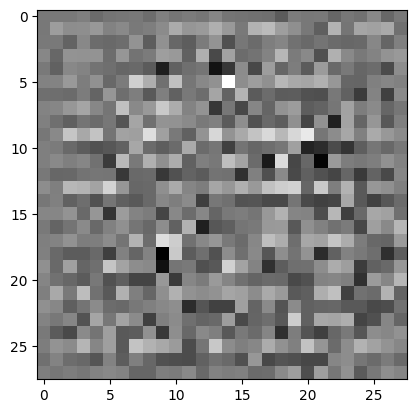

In [12]:

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_images = generator(noise, training = False)

plt.imshow(generated_images[0, :, :, 0], cmap = 'gray')

In [13]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

In [14]:
## The Discriminator Model

def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5 ), strides = (2, 2), padding = "same", input_shape = [28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.30))

  model.add(layers.Conv2D(128, (5, 5), strides= (2, 2), padding = 'same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [15]:
discriminator = make_discriminator_model()
decision = discriminator(generated_images)

print(decision)

tf.Tensor([[0.00067772]], shape=(1, 1), dtype=float32)


# Define the Loss and Optimizer

In [16]:
## This method returns a helper function to compute cross entropy loss
cross_entropy =tf.keras.losses.BinaryCrossentropy(from_logits= True)

# Discriminator Loss

In [27]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = fake_loss + real_loss

  return total_loss


# Generator Loss

In [18]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

## Generator Optimizer

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Save CheckPoints

In [20]:
checkpoint_dir = './training_chekpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [23]:
generator.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(100, 12544) dtype=float32, numpy=
 array([[-0.00987877,  0.0130415 ,  0.01263122, ..., -0.01918826,
         -0.0213676 , -0.00225576],
        [ 0.00750196, -0.01085715, -0.00992487, ..., -0.013508  ,
          0.01442957, -0.01539181],
        [-0.01014651,  0.01467646, -0.00684228, ...,  0.00127325,
          0.0098325 ,  0.01885888],
        ...,
        [ 0.01068109, -0.01855763, -0.01050054, ..., -0.00908517,
          0.02119544, -0.02168421],
        [-0.01303014, -0.01186163, -0.00298369, ..., -0.00843675,
         -0.01260671, -0.01449797],
        [ 0.01238466, -0.00920825, -0.00263933, ..., -0.02038829,
          0.00303748, -0.01939715]], dtype=float32)>,
 <tf.Variable 'batch_normalization/gamma:0' shape=(12544,) dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>,
 <tf.Variable 'batch_normalization/beta:0' shape=(12544,) dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'con

## Define the Training Loop

In [21]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

## You will reuse this seed overtime (so it's easier)
## To visualize progress in the animated GIF

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [24]:
## Notice the use of tf.function
## This annotation causes the function to be 'compiled'.

@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])


  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True)

    real_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))





In [28]:
## train the GAN

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce image for the GIF as you go
    display.clear_output(wait = True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Save the model every 15 epochs
    if(epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print("Time for epoch {} is {} sec".format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait = True)
  generate_and_save_images(generator, epochs, seed)

In [ ]:
train(train_dataset, EPOCHS)

In [30]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])


  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True)

    real_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
